<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта." data-toc-modified-id="Описание-проекта.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта.</a></span></li><li><span><a href="#Функции-для-исследования" data-toc-modified-id="Функции-для-исследования-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Функции для исследования</a></span></li><li><span><a href="#Обзор-и-предобработка-данных." data-toc-modified-id="Обзор-и-предобработка-данных.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обзор и предобработка данных.</a></span></li><li><span><a href="#Исследовательский-анализ." data-toc-modified-id="Исследовательский-анализ.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ.</a></span></li><li><span><a href="#Оценка-результатов-А/В-тестирования" data-toc-modified-id="Оценка-результатов-А/В-тестирования-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Оценка результатов А/В тестирования</a></span></li><li><span><a href="#Выводы." data-toc-modified-id="Выводы.-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы.</a></span></li></ul></div>

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import math as mth
import matplotlib.pyplot as plt

# Анализ результато А/В теста.

## Описание проекта.

**Задача:**
    
Провести оценку результатов А/В теста изменений, связанных с внедрением улучшенной рекомендательной системы.

Необходимо оценить коректность проведения теста и проанализировать результаты.

**Техническое задание:**

- Название теста: `recommender_system_test` ;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением
- улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.

**Ожидаемый эффект:**

- за 14 дней с момента регистрации пользователи покажут
  улучшение каждой метрики не менее, чем на 10%:
   - конверсии в просмотр карточек товаров — событие `product_page` ,
   - просмотры корзины — `product_cart` ,
   - покупки — `purchase`
   
 **Данные для исследовани**
 
- `final_ab_marketing_events.csv` — календарь маркетинговых событий на 2020 год.
     - Структура файла:
       - name — название маркетингового события;
       - regions — регионы, в которых будет проводиться рекламная кампания;
       - start_dt — дата начала кампании;
       - finish_dt — дата завершения кампании.
       
- `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.
   - Структура файла:
       - user_id — идентификатор пользователя;
       - first_date — дата регистрации;
       - region — регион пользователя;
       - device — устройство, с которого происходила регистрация;
       
- `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
    - Структура файла:
        - user_id — идентификатор пользователя;
        - event_dt — дата и время покупки;
        - event_name — тип события;
        - details — дополнительные данные о событии. Например, для покупок,
        - purchase, в этом поле хранится стоимость покупки в долларах.
        
- `final_ab_participants.csv` — таблица участников тестов.
    - Структура файла:
        - user_id — идентификатор пользователя;
        - ab_test — название теста;
        - group — группа пользователя.


## Функции для исследования

**Функция для обзора датафрейма**

In [2]:
# функция для обзора датафрейма
def df_overview(df):
    print('\nИнформация о таблице\n')
    df.info()
    print('\nПервые строки таблицы')
    display(df.head())
    if df.duplicated().sum()== 0:
        print('\nПолных дубликатов строк в таблице нет')
    else:
        print('\nКоличество полных дубликатов строк в таблице{}\n'.format(df.duplicated().sum()))
    n = 0    
    for i in df.columns:
        if df[i].isna().sum() != 0:
            print('\nКоличество пропусков в столбце {} - {}'.format(i, df[i].isna().sum()))
            n += 1
    if n != 0:
        print('Всего пропущенные значения есть в {} столбцах'.format(n))
    else:
        print('В столбцах таблицы нет пропущенных значений')
        
    print('\nПервичная статистика по таблице')
    display(df.describe().T)

**Функция для проверки гипотез z-критерием**

In [3]:
def check_hypothesise(successes1, successes2, trials1, trials2):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

## Обзор и предобработка данных.

Загрузим таблицы для исследования и посмотрим общую информацию по ним.

In [4]:
ab_events = pd.read_csv('final_ab_events.csv')
ab_new_users = pd.read_csv('final_ab_new_users.csv')
ab_marketing_events = pd.read_csv('final_ab_marketing_events.csv')
ab_participants = pd.read_csv('final_ab_participants.csv')

**Таблица `ab_events`**

In [6]:
df_overview(ab_events)


Информация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Первые строки таблицы


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99



Полных дубликатов строк в таблице нет

Количество пропусков в столбце details - 377577
Всего пропущенные значения есть в 1 столбцах

Первичная статистика по таблице


,count,mean,std,min,25%,50%,75%,max
details,62740.0,23.877631,72.180465,4.99,4.99,4.99,9.99,499.99



**Что можнго исправить**

- изменить формат столбца `event_dt` в формат `datetime`
- заполнить пропуски в столбце `details` 

In [7]:
ab_events['event_dt'] = pd.to_datetime (ab_events['event_dt'])
ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


Посмотрим каким событиям соответствуют проапуски в столбце `details`

In [8]:
(
    ab_events.loc[ab_events['details'].isnull()]
    .groupby('event_name')
    .agg({'user_id':'count'})
    .sort_values(by='user_id', ascending=False)
)

,user_id
event_name,
login,189552
product_page,125563
product_cart,62462


Проверим есть ли по этим событиям заполненные детали.

In [9]:
list = ['login', 'product_page', 'product_cart']
for event in list:    
    print ('Детали для события', event)
    display(ab_events.loc[ab_events['event_name'] == event, 'details'].unique())

Детали для события login


array([nan])

Детали для события product_page


array([nan])

Детали для события product_cart


array([nan])

Детали не заполнены только для событий входа в приложение, просмотр карточки товара и просмотр корзины. Эти события не имеют каких-то суммовых признаков, поэтому детали по ним не заполнены. Для исследования нам важно только количество этих событий, поэтому оставим пропуски на месте.

Посомтрим какие еще события имеются в датафрейме

In [10]:
(
    ab_events
    .groupby('event_name')
    .agg({'user_id':'count'})
    .sort_values(by='user_id', ascending=False)
)

,user_id
event_name,
login,189552
product_page,125563
purchase,62740
product_cart,62462


Всего 4 вида событий. В деталях заполнены только данные о сумме покупки. 

In [11]:
print(
    'Таблица содержит данные за период с {} по {}'
    .format(
        ab_events['event_dt'].dt.date.min(),
        ab_events['event_dt'].dt.date.max()
    ),
    '\nДействия {} уникальных пользователей'
    .format(ab_events['user_id'].nunique()),
    '\nУникальных событий {}, всего событий {}'
    .format (
        ab_events['event_name'].nunique(),
        ab_events['event_name'].count()
    )
)

Таблица содержит данные за период с 2020-12-07 по 2020-12-30 
Действия 58703 уникальных пользователей 
Уникальных событий 4, всего событий 440317


Также из первичной статистики можно увидеть, что основная часть покупок на сумму 4.99$ (медиана и минимальное значения покупки совпадают), максимальная покупка на сумму 499.99 

**Таблица `ab_new_users`**

In [12]:
df_overview(ab_new_users)


Информация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB

Первые строки таблицы


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone



Полных дубликатов строк в таблице нет
В столбцах таблицы нет пропущенных значений

Первичная статистика по таблице


,count,unique,top,freq
user_id,61733,61733,3CF470277C9DD165,1
first_date,61733,17,2020-12-21,6290
region,61733,4,EU,46270
device,61733,4,Android,27520


**Что можно исправить:**
- формат столбца `first_date` преобразовать в `datetime`

In [13]:
ab_new_users['first_date'] = pd.to_datetime (ab_new_users['first_date'])
ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


Проверим уникальные значения столбцов `region` и `device`

In [14]:
display(ab_new_users['region'].unique())
ab_new_users['device'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

В значениях столбцов нет скрытых дубликатов.

Посмотрим статистику после преобразования даты

In [15]:
ab_new_users.describe().T

/tmp/ipykernel_225/1819616377.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  ab_new_users.describe().T


,count,unique,top,freq,first,last
user_id,61733,61733,3CF470277C9DD165,1,NaT,NaT
first_date,61733,17,2020-12-21 00:00:00,6290,2020-12-07,2020-12-23
region,61733,4,EU,46270,NaT,NaT
device,61733,4,Android,27520,NaT,NaT


Таблица `ab_new_users` содержит данные о 61733 пользователях, зарегистрировавшихся за период с 7 декабря 2020 г. по 23 декабря 2020 г. Пользователи из 4-х регионов- Европы, Северной Америки, стран Азиатско-Тихоокеанского региона и стран СНГ, чаще всего регистрировались пользователи из Европы. Пользователи испульзуют 4 типа устройств - PC, Android, iPhone и MAC, самое популярное - Android. 

**Таблица `ab_marketing_events`**

In [16]:
df_overview(ab_marketing_events)


Информация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes

Первые строки таблицы


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11



Полных дубликатов строк в таблице нет
В столбцах таблицы нет пропущенных значений

Первичная статистика по таблице


,count,unique,top,freq
name,14,14,Dragon Boat Festival Giveaway,1
regions,14,6,APAC,4
start_dt,14,14,2020-12-30,1
finish_dt,14,14,2020-11-12,1


**Что можно исправить**

- преобразовать формат столбцов `start_dt` и `finish_dt` в `datetime`

In [17]:
ab_marketing_events['start_dt'] = pd.to_datetime (ab_marketing_events['start_dt'])
ab_marketing_events['finish_dt'] = pd.to_datetime (ab_marketing_events['finish_dt'])
ab_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


Посмотрим на таблицу целиком

In [18]:
ab_marketing_events.sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


В таблице промоакции на 2020 г. с датой начала и окончания, регионами проведения. Всего 14 промоакций. 

С периодом проведения и аудиторией A/B теста пересекается 1 акция - "Christmas&New Year Promo" - она проходит в том числе для стран Европы в период с 25 декабря до 03 января.

**Таблица `ab_participants`**

In [19]:
df_overview(ab_participants)


Информация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB

Первые строки таблицы


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test



Полных дубликатов строк в таблице нет
В столбцах таблицы нет пропущенных значений

Первичная статистика по таблице


,count,unique,top,freq
user_id,18268,16666,FF2174A1AA0EAD20,2
group,18268,2,A,9655
ab_test,18268,2,interface_eu_test,11567


Таблица содержит даные об участниках 2-х тестов: `recommender_system_test` - исследуемый тест, `interface_eu_test` - конкурирующий тест.

Сторк в таблице 18268, а уникальных пользователей 16666. Значит есть пользователи, либо попавшие в оба теста, либо в 2 группы одного теста проверим это.

In [20]:
for test in ab_participants['ab_test'].unique():
    print (
        'Число участников теста {} - {},\nУникальных пользователей в тесте {}'
        .format(
            test,
            ab_participants.query('ab_test ==@test')['user_id'].count(),
            ab_participants.query('ab_test ==@test')['user_id'].nunique()
            
        ),
        'Пользователей попавших в обе группы {} ({} %)'
        .format(
           (ab_participants.query('ab_test ==@test')['user_id'].count()-
           ab_participants.query('ab_test ==@test')['user_id'].nunique()),
            round(
                (ab_participants.query('ab_test ==@test')['user_id'].count()-
                ab_participants.query('ab_test ==@test')['user_id'].nunique()) / 
                ab_participants.query('ab_test ==@test')['user_id'].nunique() *
                100, 2
            )
        )
    )

Число участников теста recommender_system_test - 6701,
Уникальных пользователей в тесте 6701 Пользователей попавших в обе группы 0 (0.0 %)
Число участников теста interface_eu_test - 11567,
Уникальных пользователей в тесте 11567 Пользователей попавших в обе группы 0 (0.0 %)


Пользователей пересекающихся между A/B группами тестов нет.
Значит есть пользователи, участвующие в конкурирующих тестах. Группы А - это контрольные группы, по идеи для них одинаковые условия в обоих тестах, поэтому нам достаточно выявить только пересекающихся пользователей по группе B

Условия проверки:

1. Пользователи из конкурируещего теста группы В попавшие в нашу тестовую группу В
2. Пользователи из конкурируещего теста группы В попавшие в нашем тесте в группу А

In [22]:
users_compet_test_a = ab_participants.query('ab_test == "interface_eu_test" and group == "A"')['user_id']
users_compet_test_b = ab_participants.query('ab_test == "interface_eu_test" and group == "B"')['user_id']

users_exclude_b =(
    ab_participants
    .query(
        '(ab_test == "recommender_system_test" and group == "B") and (user_id in @users_compet_test_b)'
    )['user_id']
)

users_exclude_a =(
    ab_participants
    .query(
        'ab_test == "recommender_system_test" and group == "A"and user_id in @users_compet_test_b'
    )['user_id']
)


print(
    'Всего пользователей из группы В, учавствующих в конкурирующем тесте - {}'
    .format(len(users_exclude_b)),
    '\nЭто {} % участников теста "recommender_system_test"'
    .format(
        round(
            len(users_exclude_b) /
            ab_participants.query('ab_test =="recommender_system_test"')['user_id'].nunique() *100,
            2
        )        
    ),
    '\n\nВсего пользователей из группы А, учавствующих в конкурируещем тесте в группе В - {}'
    .format(len(users_exclude_a)),
    '\nЭто {} % участников теста "recommender_system_test"'
    .format(
        round(
            len(users_exclude_a) /
            ab_participants.query('ab_test =="recommender_system_test"')['user_id'].nunique() *100,
            2
        )        
    ),
)



Всего пользователей из группы В, учавствующих в конкурирующем тесте - 344 
Это 5.13 % участников теста "recommender_system_test" 

Всего пользователей из группы А, учавствующих в конкурируещем тесте в группе В - 439 
Это 6.55 % участников теста "recommender_system_test"


Для анализа результатов теста "recommender_system_test" создадим таблицу с участниками этого теста, которые не пересекаются с конкурирующим тестом

In [23]:
participants_rec_test = (
    ab_participants
    .query('ab_test =="recommender_system_test" and (user_id not in @users_exclude_a and user_id not in @users_exclude_b)')
)
participants_rec_test.info()
participants_rec_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  5918 non-null   object
 1   group    5918 non-null   object
 2   ab_test  5918 non-null   object
dtypes: object(3)
memory usage: 184.9+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Добавим к получившейся таблице данные из таблицы с новыми пользователями `ab_new_users`.

In [24]:
participants_rec_test = (
    participants_rec_test
    .merge(ab_new_users, on='user_id', how='inner')
)

In [25]:
participants_rec_test.info()
participants_rec_test.describe().T


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5918 entries, 0 to 5917
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     5918 non-null   object        
 1   group       5918 non-null   object        
 2   ab_test     5918 non-null   object        
 3   first_date  5918 non-null   datetime64[ns]
 4   region      5918 non-null   object        
 5   device      5918 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 323.6+ KB


/tmp/ipykernel_225/2389841950.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  participants_rec_test.describe().T


,count,unique,top,freq,first,last
user_id,5918,5918,B8EF6F0325A9979F,1,NaT,NaT
group,5918,2,A,3385,NaT,NaT
ab_test,5918,1,recommender_system_test,5918,NaT,NaT
first_date,5918,15,2020-12-21 00:00:00,639,2020-12-07,2020-12-21
region,5918,4,EU,5568,NaT,NaT
device,5918,4,Android,2656,NaT,NaT


Получилось 5918 участников теста. Пользователей из Европы - 5568, их количество меньше ожидаемого (ожидаемое - 6000). Проверим соответствует ли это предполагаемой доли новых пользователей из Европы - 15%. Дата остановки набора пользователей соответстветствует ТЗ.

In [26]:
print(
    'Всего новых пользователей из Европы, зарегистрировавшихся в период с 07 по 21 декабря - {}'
    .format(
        len(ab_new_users
            .loc[(ab_new_users['region'] =='EU') &  (ab_new_users['first_date'] <= '2020-12-21')])
    ),
    '\nУчастники теста составляют - {} %'
    .format(
        round(
            len(participants_rec_test.loc[(participants_rec_test['region'] =='EU')]) /
            len(ab_new_users
            .loc[(ab_new_users['region'] =='EU') &  (ab_new_users['first_date'] <= '2020-12-21')]) *100,
            2
        )
    )
)

Всего новых пользователей из Европы, зарегистрировавшихся в период с 07 по 21 декабря - 42340 
Участники теста составляют - 13.15 %


**Распределение пользователей по регионам**

Сравним распределение тестовых групп новых пользователей и основной группы новых пользователей по регионам.

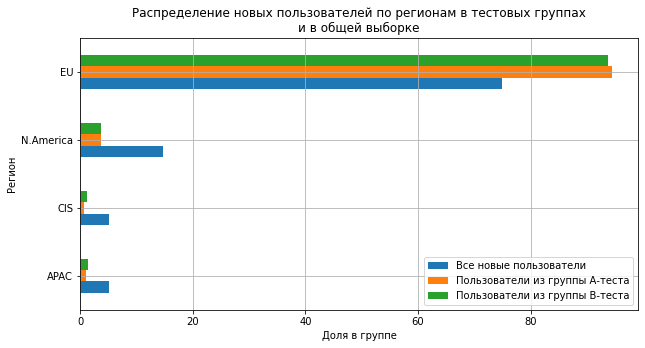

,number_of_users,%_users,number_of_a_users,%_a_users,number_of_b_users,%_b_users
region,,,,,,
EU,42340,74.98,3195,94.39,2373,93.68
N.America,8347,14.78,128,3.78,95,3.75
CIS,2900,5.14,25,0.74,30,1.18
APAC,2883,5.11,37,1.09,35,1.38


In [27]:
users_by_region = (
    ab_new_users.query('first_date <= "2020-12-21"')
    .groupby('region')
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'number_of_users'})
    .reset_index()
)
users_by_region['%_users'] = round(
    users_by_region['number_of_users'] / users_by_region['number_of_users'].sum() *100, 2
)

a_users_by_region = (
    participants_rec_test.query('group == "A"')
    .groupby('region')
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'number_of_a_users'})
    .reset_index()
)

a_users_by_region['%_a_users'] = round(
    a_users_by_region['number_of_a_users'] / a_users_by_region['number_of_a_users'].sum() *100, 2
)

b_users_by_region = (
    participants_rec_test.query('group == "B"')
    .groupby('region')
    .agg({'user_id': 'count'})
    .rename(columns={'user_id': 'number_of_b_users'})
    .reset_index()
)

b_users_by_region['%_b_users'] = round(
    b_users_by_region['number_of_b_users'] / b_users_by_region['number_of_b_users'].sum() *100, 2
)

users_by_region = (
    users_by_region.merge(a_users_by_region, on='region')
    .merge(b_users_by_region, on='region')
    .set_index('region')
)


(
    users_by_region[['%_users','%_a_users', '%_b_users']]
    .sort_values(by='%_users')
    .plot(kind='barh', figsize=(10, 5), grid=True)
)
plt.title('Распределение новых пользователей по регионам в тестовых группах\nи в общей выборке')
plt.legend(['Все новые пользователи', 'Пользователи из группы А-теста', 'Пользователи из группы В-теста'])
#plt.legend(title='Регион')
plt.ylabel('Регион')
plt.xlabel('Доля в группе')
#plt.tight_layout()
plt.show()

users_by_region.sort_values(by='%_users', ascending=False)

Как видно распределение пользователей по регионам отличаются как в общей группе от тестовой, так и между тестовыми группами. Между тестовыми группами различия не такие значительные, как основной группы от тестовой. 

Тестовые группы отличаются между собой еще и по количеству пользователей. Посчитаем на сколько

In [28]:
print(
    'Всего пользователей в группе А - {}'.
    format(users_by_region['number_of_a_users'].sum()),
    '\nВсего пользователей в группе B - {}'.
    format(users_by_region['number_of_b_users'].sum()),
    '\nВ группе В пользователей на {:.2%} меньше'
    .format(
        1 - (users_by_region['number_of_b_users'].sum() / users_by_region['number_of_a_users'].sum())        
    ),
    '\n\nПользователей из Европы в группе А - {}'.
    format(users_by_region['number_of_a_users'].loc['EU']),
    '\nПользователей из Европы в группе B - {}'.
    format(users_by_region['number_of_b_users'].loc['EU']),
    '\nВ группе В пользователей из Европы на {:.2%} меньше'
    .format(
        1 - (users_by_region['number_of_b_users'].loc['EU'] / users_by_region['number_of_a_users'].loc['EU'])
    )
    
)

Всего пользователей в группе А - 3385 
Всего пользователей в группе B - 2533 
В группе В пользователей на 25.17% меньше 

Пользователей из Европы в группе А - 3195 
Пользователей из Европы в группе B - 2373 
В группе В пользователей из Европы на 25.73% меньше


**Распределение пользователей по датам**

добавим к таблице с пользователями признак участия/неучастия в тесте

In [29]:
ab_new_users['test_group'] = 'not_in_test'
ab_new_users.loc[ab_new_users['user_id'].isin(participants_rec_test.query('group == "B"')['user_id']), 'test_group'] = 'B'

ab_new_users.loc[ab_new_users['user_id'].isin(participants_rec_test.query('group == "A"')['user_id']), 'test_group'] = 'A'

ab_new_users.head()

,user_id,first_date,region,device,test_group
0,D72A72121175D8BE,2020-12-07,EU,PC,A
1,F1C668619DFE6E65,2020-12-07,N.America,Android,not_in_test
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,not_in_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,not_in_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,not_in_test


Посмотрим на распределение новых пользователей по датам

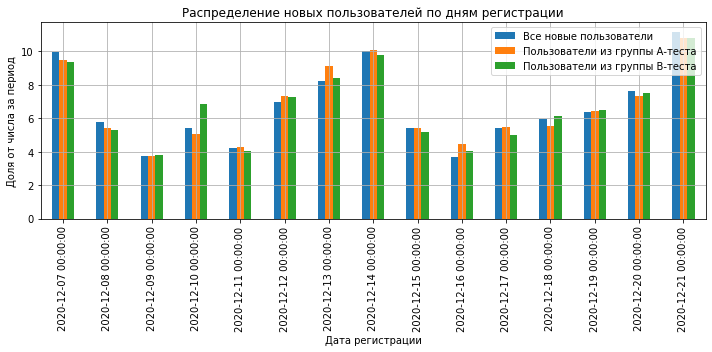

In [30]:
users_by_day = (
    ab_new_users.query('first_date <= "2020-12-21"')
    .pivot_table(index='first_date', columns='test_group', values='user_id', aggfunc='count')
)
users_by_day['%_A'] = (
    round(users_by_day['A'] / users_by_day['A'].sum() * 100, 2)
)

users_by_day['%_B'] = (
    round(users_by_day['B'] / users_by_day['B'].sum() * 100, 2)
)

users_by_day['%_not_in_test'] = (
    round(users_by_day['not_in_test'] / users_by_day['not_in_test'].sum() * 100, 2)
)
(
    users_by_day[['%_not_in_test', '%_A', '%_B']]
    .plot(kind='bar',  figsize=(10, 5), grid=True)
)
plt.title('Распределение новых пользователей по дням регистрации')
plt.legend(['Все новые пользователи', 'Пользователи из группы А-теста', 'Пользователи из группы В-теста'])
#plt.legend(title='Регион')
plt.ylabel('Доля от числа за период')
plt.xlabel('Дата регистрации')
plt.tight_layout()
plt.show()

В целом пользователеи участники теста и все пользователи распределены по датам привлечения соразмерно, за исключением 10 декабря, где привлечено немного больше пользователей группы В.

Согласно ТЗ мы оцениваем метрики пользователей из Европы на 14 день после регистрации, поэтому оставим в таблице для исследования только действия пользователей из Европы пределах 14 дней после регистрации.

In [31]:
ab_events_test = (
    participants_rec_test.query('region == "EU"')
    .merge(ab_events, on='user_id', how='left')
)

In [32]:
ab_events_test['lifetime'] = (ab_events_test['event_dt'] - ab_events_test['first_date']).dt.days

ab_events_eu = ab_events_test.loc[ab_events_test['lifetime'] <= 14]
ab_events_eu.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,0.0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,0.0
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,0.0
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,login,NaN,0.0
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone,2020-12-20 15:46:06,product_page,NaN,0.0


In [33]:
ab_events_eu.info()
ab_events_eu.describe().T


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20034 entries, 0 to 23081
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     20034 non-null  object        
 1   group       20034 non-null  object        
 2   ab_test     20034 non-null  object        
 3   first_date  20034 non-null  datetime64[ns]
 4   region      20034 non-null  object        
 5   device      20034 non-null  object        
 6   event_dt    20034 non-null  datetime64[ns]
 7   event_name  20034 non-null  object        
 8   details     2736 non-null   float64       
 9   lifetime    20034 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 1.7+ MB


,count,mean,std,min,25%,50%,75%,max
details,2736.0,22.877427,69.705936,4.99,4.99,4.99,9.99,499.99
lifetime,20034.0,2.924428,3.470217,0.00,0.00,2.00,5.00,14.00


В таблице осталось 20034 события пользователей, из них 2736 покупок.

**Вывод**

На этапе предобработки возникли следующие проблемы с данными:
- несоответствие типов данных - столбцы содержащие дату были в формате `object`;
- пропуски в таблице `ab_events` в столбце `details`, которые обусловлены отстутстсвием числовых характеристик у действий входа в приложение, просмотра карточки товара и просмотра карзины - мы оставили эти данные незаполненными; 
    
Обнаружены несоответствия данных техинческому заданию:
 
 - несоответствие периодов данных событий дате остановке А/В теста - события в датасете с 07 по 30 декабря 2020, дата остановки теста по ТЗ 04 января 2021 г.;
 - аудитория теста меньше заявленной в ТЗ (15% новых пользователей из Европы), фактически 13.2%.

Период проведения теста совпал с маркетинговым событием для регион Европа - `Christmas&New Year Promo`. 

Также выявлено пересечение аудиторий двух конкурирующих тестов.

Различаются распределения пользователей по регионам в тестовой группе и в общей выборке. Доля пользователй из Европы в общей выборке меньше на 20%, чем в тестовой группе. Разница в распределении пользователй по регионам между тестовыми группами А и В для пользователей Европы 0.71%, для остальных регионов 0.03-0.44% . Т.е. относительно групп А и В пользователи распределены по регионам более-менее равномерно, но это распределение не соответствует распределению в основной выборке.

Количество пользователей в тестовой группе B меньше на 26% чем в тестовой группе А, что также может исказить результаты теста.

Распределение пользователей в тестовых группах по дням соответствует распределению по дням в основной выборке.

Из-за существующих несоответствий техническому заданию, возможного влияния на результаты маркетенгого события, проходящего одновременно с тестом, а также несоответствия распределения по регионам тестовой и основной группы, к итогам данного A/B тестирования следует относится осторожно. В целом, в этом случае следует провести А/В тест повторно, исправив технические ошибки, которые привели к появлению пересекающихся пользователей и отличиям распределений по регионам, выбрав период без маркетинговых мероприятий.Но так как у нас нет такой возможности, проведем анализ A/B теста на основе имеющихся данных.

## Исследовательский анализ.

**Распределение событий в тестовых группах**

**1 По пользователям**

Посмотрим на распределение событий по пользователям в группах.

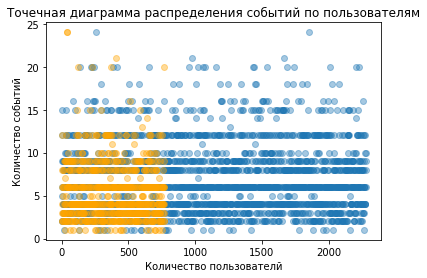

Из тестовой группы А в приложении совершили события 2279 пользователей
Это 71.33% пользователей из группы 

Из тестовой группы B в приложении совершили события 771 пользователей
Это 32.49% пользователей из группы


In [34]:
events_by_users_a = (
    ab_events_eu.query('group =="A"')
    .groupby('user_id')
    .agg({'event_name' : 'count'})    
)

events_by_users_b = (
    ab_events_eu.query('group =="B"')
    .groupby('user_id')
    .agg({'event_name' : 'count'})    
)

x_values_a = pd.Series(range(0,len(events_by_users_a)))
x_values_b = pd.Series(range(0,len(events_by_users_b)))

plt.scatter(x_values_a, events_by_users_a['event_name'], alpha=0.4)
plt.scatter(x_values_b, events_by_users_b['event_name'], color='orange', alpha=0.4)
plt.title('Точечная диаграмма распределения событий по пользователям')
plt.ylabel('Количество событий')
plt.xlabel('Количество пользователй')
plt.show()

print(
    'Из тестовой группы А в приложении совершили события {} пользователей\nЭто {:.2%} пользователей из группы'
    .format(
        len(events_by_users_a),
        len(events_by_users_a) / len(participants_rec_test.query('region == "EU" and group == "A"'))
    ),
    '\n\nИз тестовой группы B в приложении совершили события {} пользователей\nЭто {:.2%} пользователей из группы'
    .format(
        len(events_by_users_b),
        len(events_by_users_b) / len(participants_rec_test.query('region == "EU" and group == "B"'))
    )
)

В обоеих группах основная часть пользователей совершает до 10 событий приложении. Также в группах есть пользователи, совершившие аномально большое количество событий.

Однако в группе А в целом выше доля пользователей, совершивших событие (их 71%), а в группе B событие совершили всего 32% пользователей.

Посмотрим на гистограмму распределения событий.

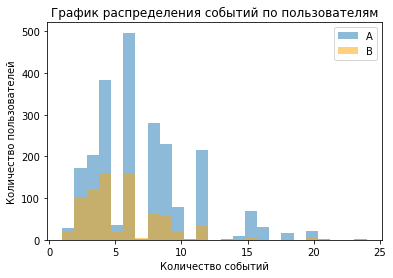

In [35]:
plt.hist(events_by_users_a['event_name'], bins=25, alpha=0.5, label='A')
plt.hist(events_by_users_b['event_name'], bins=25, color='orange', alpha=0.5, label='B')
plt.title('График распределения событий по пользователям')
#plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
#plt.axis([0, 25, 0, 700])
plt.show()

В целом оба распределения мпохожи на нормальные со смещением в правую сторону (из-зи наличия неюольшого количества пользователей с аномально большим числом событий).

**2 Распределение событий в группах по дням**

In [36]:
ab_events_eu['date'] = ab_events_eu['event_dt'].dt.date

/tmp/ipykernel_225/429463434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_events_eu['date'] = ab_events_eu['event_dt'].dt.date


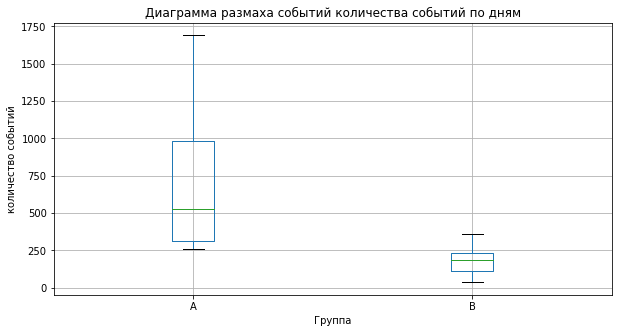

In [37]:
(
    ab_events_eu
    .pivot_table(index='date', columns='group', values='event_name', aggfunc='count')
    .reset_index()
    .boxplot(column=['A', 'B'], figsize=(10, 5))    
)

plt.title('Диаграмма размаха событий количества событий по дням')
plt.ylabel('количество событий')
plt.xlabel('Группа')
plt.show() 



Как видно количество событий по дням сильно отличаются между группами. Медианное количество событий в день для группы А около 600, для группы В - около 200. Также для группы А характерен больший разброс значений. Количество событий в день в группе В распределены более равномерно.

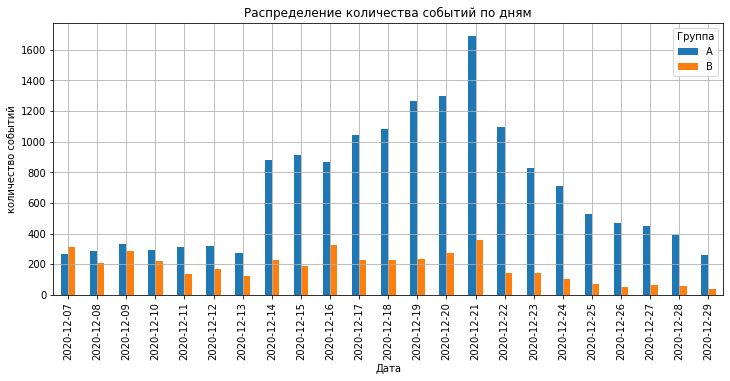

In [38]:
(
    ab_events_eu
    .pivot_table(index='date', columns='group', values='event_name', aggfunc='count')
    .plot(kind='bar', grid=True, figsize=(12, 5))    
)

plt.title('Распределение количества событий по дням')
plt.ylabel('количество событий')
plt.xlabel('Дата')
plt.legend(title='Группа')
plt.show() 


График распределения по дням подтверждает выоды диаграммы размаха. У группы А наблюдается резкое увеличения числа событий с 14 по 22 декабря. Затем число событий постепенно уменьшается, но тем не менее остается значительно выше, чем в первую неделю эксперимента. У группы В такого скачка не наблюдается, но также есть спад количества событий в последнюю неделю эксперимента.
Возможно такой всплеск активности связан с предпразничной неделей, в этом случае не понятно, почему активность пользователей из группы В не изменилась.

**Конверсия в события**

**Таблица с куммулятивными данными**

Для анализа куммулятивных данных по группам создадим таблицу с ними.

In [39]:
dates_groups = ab_events_eu[['date','group']].drop_duplicates()

orders = ab_events_eu.query('event_name =="purchase"')

orders_aggregated = (
    dates_groups
    .apply(
        lambda x: orders[
            np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])
        ]
        .agg(
            {'date' : 'max', 'group' : 'max', 'event_dt' : 'count', 'user_id' : 'nunique', 'details' : 'sum'}
        ), axis=1
    ).sort_values(by=['date','group'])
    .rename(columns={'event_dt': 'orders', 'user_id' : 'buyers', 'details' : 'revenue'})
)

product_page_dt = ab_events_eu.query('event_name =="product_page"')

product_page_aggregated = (
    dates_groups
    .apply(
        lambda x: product_page_dt[
            np.logical_and(product_page_dt['date'] <= x['date'], product_page_dt['group'] == x['group'])
        ]
        .agg(
            {'date' : 'max', 'group' : 'max', 'event_dt' : 'count', 'user_id' : 'nunique'}
        ), axis=1
    ).sort_values(by=['date','group'])
    .rename(columns={'event_dt': 'page_number', 'user_id' :'page_users'})
)

product_cart_dt = ab_events_eu.query('event_name =="product_cart"')

product_cart_aggregated = (
    dates_groups
    .apply(
        lambda x: product_cart_dt[
            np.logical_and(product_cart_dt['date'] <= x['date'], product_cart_dt['group'] == x['group'])
        ]
        .agg(
            {'date' : 'max', 'group' : 'max', 'event_dt' : 'count', 'user_id' : 'nunique'}
        ), axis=1
    ).sort_values(by=['date','group'])
    .rename(columns={'event_dt': 'cart_number', 'user_id' :'cart_users'})
)

visitors = ab_events_eu.query('event_name =="login"')

visitors_aggregated = (
    dates_groups
    .apply(
        lambda x: visitors[
            np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])
        ].agg(
            {'date' : 'max', 'group' : 'max', 'event_dt' : 'count', 'user_id' : 'nunique'}
        ), axis=1
    ).sort_values(by=['date','group'])
    .rename(columns={'event_dt': 'login_number', 'user_id' :'login_users'})
)

cumulative_data = (
    orders_aggregated
    .merge(product_page_aggregated, on=['date', 'group'])
    .merge(product_cart_aggregated, on=['date', 'group'])
    .merge(visitors_aggregated, on=['date', 'group'])
)
#cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

**График куммулятивной конверсии по группам**

для построения графика посчитаем конверсии групп в целлевые события теста

In [40]:
cumulative_data['conversion'] = cumulative_data['buyers'] / cumulative_data['login_users']
cumulative_data['conv_page'] = cumulative_data['page_users'] / cumulative_data['login_users']
cumulative_data['conv_cart'] = cumulative_data['cart_users'] / cumulative_data['login_users']
cumulative_data_а = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

Построим график конверсий по целевым действиям.

Графики конверсии по целевым метрикам теста


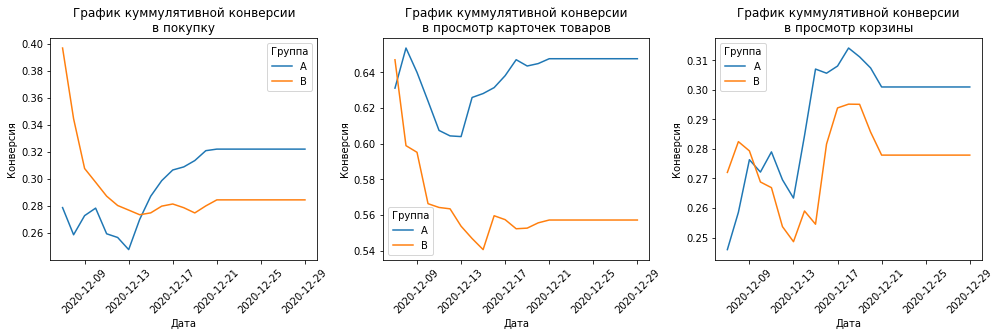

In [41]:
plt.subplots(figsize=(14,8))
selected_columns = [
    'conversion',
    'conv_page',
    'conv_cart'
]
plot_names = [
    'покупку',
    'просмотр карточек товаров',
    'просмотр корзины'
]

print('Графики конверсии по целевым метрикам теста')
for plot_num, column in enumerate(selected_columns):
    ax=plt.subplot(2, len(selected_columns),plot_num+1)
    plt.plot(
        cumulative_data_а['date'],
        cumulative_data_а[column],
        label='A'
        #ax=plt.subplot(1, len(selected_columns),plot_num+1),
        #grid=True        
    )
    plt.plot(
        cumulative_data_b['date'],
        cumulative_data_b[column],
        label='B'
        #ax=plt.subplot(1, len(selected_columns),plot_num+1),
        #grid=True
    )
    
    plt.title(f'График куммулятивной конверсии\nв {plot_names[plot_num]}')
    plt.ylabel('Конверсия')
    plt.xlabel('Дата')
    plt.legend(title='Группа')
    plt.xticks(rotation=45)
    #plt.xticks([0, 1])
    plt.tight_layout()

В начале теста группа B была лучше по всем метрикам. 

Конверсия в покупку группы В резко сокращается и после 14 декабря стабилизируется на уровне около 28%, конверсия в покупку группы А также падает до 13.12, а затем начинает резко расти (как раз в тот период, когда мы наблюдали резкий рост привлеченных за день пользователей у группы), где-то с 21.12 коммулятивная конверсия группы А стабилизируется и остается на уровне 32% до конца теста.

Конверсия в просмотр карточек у группы В резко падает с начала теста и до 14.12, затем происходит неблольшой рост и показатель фиксируется с 18.12 примерно на 56% до конца теста. Конверсия в просмотр карточек группы А тоже сокращается до 14.12, затем начинает расти и стабилизируется с 21.12 до конца теста примерно на 65%.

Аналогично предыдущим метрикам конверсия в просмотр корзины у группы В падает до 13.12, затем происходит скачок показателя, но после 18-19 декабря конверсия вновь начинает снижаться и фиксируется с 21.12 примерно на 29%. График коммулятивной конверсии в просмотр корзины группы А похож по динамике, но начиная с 10.12 конверсия группы А остается выше конверсии группы В до конца теста. Показатель также фиксируется 21.12 на уровне около 30%.

Стабилизация происходит, потому что после 21.12 прекратился набор новых пользователей в группы, число пользователей совершивших событие уже не меняется до конца эксперимента.

**Графики относительных различий куммулятивных конверсий.**

Объединим конверсии групп А и В в одну таблицу

In [42]:
merge_cumulative_conv =(
    cumulative_data_а[['date', 'conversion', 'conv_page', 'conv_cart']]
    .merge(cumulative_data_b[['date', 'conversion', 'conv_page', 'conv_cart']], on='date', how='left', suffixes=['_a', '_b'])
)

Построим графики относительных различий конверсий групп по метрикам теста.

Графики относительного изменения куммулятивных конверсий


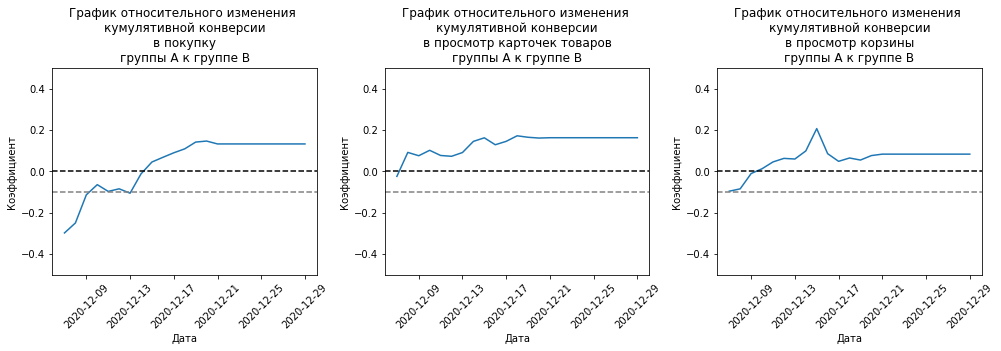

In [43]:
plt.subplots(figsize=(14,8))
selected_columns_a = [
    'conversion_a',
    'conv_page_a',
    'conv_cart_a'
]

columns_b = [
    'conversion_b',
    'conv_page_b',
    'conv_cart_b'
]

plot_names = [
    'покупку',
    'просмотр карточек товаров',
    'просмотр корзины'
]

print('Графики относительного изменения куммулятивных конверсий')
for plot_num, column in enumerate(selected_columns_a):
    ax=plt.subplot(2, len(selected_columns),plot_num+1)
    plt.plot(
        merge_cumulative_conv['date'],
        (merge_cumulative_conv[column] / merge_cumulative_conv[columns_b[plot_num]]-1)
    )   
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=-0.1, color='grey', linestyle='--')
    #plt.axis(["2020-12-07", '2020-12-30', -0.5, 0.5])
    plt.ylim(-0.5, 0.5)
    plt.title(f'График относительного изменения \nкумулятивной конверсии\nв {plot_names[plot_num]}\nгруппы А к группе В')
    plt.xticks(rotation=45)
    plt.xlabel('Дата')
    plt.ylabel('Коэффициент')
    plt.tight_layout()
#plt.show()

По графикам относительных изменений конверсий также мвидно, что в начале по конверсиив покупку и просмотр корзины лидировала группа В, но около 13 декабря группа А опередила группу В. Конверсия в просмотр карточек у группы А выше практически с самого начала теста.

Наш тест проверяет изменения, связанные с улучшением рекомендательной системы. При этом уже изначально тестовая группа меньше контрольной на 25%. В приложении совершают действия только 71% из контрольной группы и 32% из тестовой. Фактически только эти пользователи участвуют в тестировании рекомендательной системы. Соответственно тестовая группа B меньше контрольной на 66%. Пользователи группы А более активно заходили в приложение после 14 декабря. Они явно имеют отличия от группы В, поэтому нельзя объективно оценить эффективность изменений в приложении, сравнивая действия этих двух групп.

## Оценка результатов А/В тестирования

Результаты А/В теста показывают, что у  тестовой группы В по всем трем метрикам теста (конверсии в просмотр карточек, конверсии в просмотр корзины и конверсии в покупку) показатели хуже, соответственно ожидаемый эффект от улучшения рекомендательной системы не достигнут. 

Проведем статистическую проверку разницы конверсий z-критерием.

Всего мы проводим три сравнения конверсий групп А и В - в покупку, в просмотр карточки продукта, в просмотр корзины)

Уровень значимости `alpha` для проверки равен **0,05**.

Скорректируем его с учетом множественных сравнений, применив метод Шидака. 

In [44]:
alpha = 1 - (1 - 0.05)**(1/3)
print('Уровень значимости для проверки равенства долей равен', round(alpha, 3))

Уровень значимости для проверки равенства долей равен 0.017


**Сформулируем гипотезу**

**Нулевая гипотеза** - Конверсии в событие двух генеральных совокупностей выборок контрольной группы А и тестовой В равны.

**Альтернативная гипотеза** - Конверсии в событие двух генеральных совокупностей выборок групп А и В различаются.

Посчитаем размеры групп и количество пользователей, совершивших целевые события в приложении.

In [45]:
successes = (
    cumulative_data.groupby('group')
    .agg({'buyers': 'max', 'page_users' : 'max', 'cart_users': 'max'})
    .rename(columns={'buyers':'purchase', 'page_users':'product_page', 'cart_users':'product_cart'})
)

trials = (
    cumulative_data.groupby('group')
    .agg({'login_users' : 'max'})    
)

display(successes)
trials

,purchase,product_page,product_cart
group,,,
A,734,1476,686
B,219,429,214


,login_users
group,
A,2279
B,770


In [46]:
for event in successes.columns:
    p_value = check_hypothesise(successes.loc['A', event],
                                successes.loc['B', event],
                                trials.loc['A', 'login_users'],
                                trials.loc['B', 'login_users'])                               
    if p_value < alpha:
        print(
            f'\nДля события {event}:',
            f'\nОтвергаем нулевую гипотезу: \nмежду долями по событию в группах есть значимая разница\n',
            'p_value=', round(p_value, 3)
        )
    else:
        print(
            f'\nДля события {event}:',            
            f'\nНе получилось отвергнуть нулевую гипотезу,\nнет оснований считать доли групп по событию разными\n',
            'p_value=', round(p_value, 3),'\n'
        )


Для события purchase: 
Не получилось отвергнуть нулевую гипотезу,
нет оснований считать доли групп по событию разными
 p_value= 0.051 


Для события product_page: 
Отвергаем нулевую гипотезу: 
между долями по событию в группах есть значимая разница
 p_value= 0.0

Для события product_cart: 
Не получилось отвергнуть нулевую гипотезу,
нет оснований считать доли групп по событию разными
 p_value= 0.225 



Проверка z-критерием показала

- по метрике **Конверсия в покупку** вероятность, что конверсии контрольной и тестовой групп не отличаются выше статистически значимой. У нас нет оснований отвергнуть нулевую гипотезу.

- по метрике **Конверсия в просмотр карточек товаров** подтвердилось наличие статистически значимого различия в конверсиях групп А и В. Мы можем отвергнуть нулевую гипотезу и не отвергать альтернативную.

- по метрике **Просмотр Корзины** Вероятность что конверсии двух групп одинаковы выше статистически значимой. У нас нет оснований отвергнуть нулевую гипотезу.

Конверсия группы В по всем целевым событиям была ниже, чем у группа А. Но на основании статистической проверки можно сделать вывод, что вероятнее всего различия в конверсиях событий `purchase` и `product_cart` случайны. Наличие же статистически значимых различии в конверсии в шаг `product_page` подтвердилось.



## Выводы.

**Итоги А/В теста.**

В ходе исследовательского анализа мы выяснили

- в приложении совершали действия 71% пользователей из контрольной группы и только 32% пользователей из тестовой группы;
- пользователи в контрольной и в тестовой группе в основном совершают до 10 событий в приложении. Однако в обеих группах есть отдельные пользователи с аномально большим количеством событий (20-25);
- число событий в день у групп сильно различается для контрольной группы медианное значение около 600 событий в день, для тестовой около 200;
- у контрольной группы начиная с 14 декабря наблюдается резкий рост событий в день, при том, что активность пользователей из группы В не изменилась, возможно это связано с предпразничной неделей, на пользователей группы А оказало влияние какое-то внешнее событие, которое не отразилось на пользователях из тестовой группы;
- тестовая группа показала худшие результаты по всем метрикам теста, по сравнению с контрольной.

Проверка различий конверсий целевых шагов между группами подтвердила наличие статистически значимой разницы только в конверсии в просмотр карточек товара. Вероятность что конверсии контрольной и тестовй групп в покупку и просмотр корзины не отличаются, а различия выявленные в выборках случайны - выше статистически значимой.

В итоге эксперимента ожидаемого эффекта роста целевых метрик с внедрением улучшенной рекомендательной системы не выявлено.

**Корректность А/В теста**

На этапе обзора и подготовки данных мы выявили

- Несоответствие периодов данных событий дате остановке А/В теста - события в датасете с 07 по 30 декабря 2020, дата остановки теста по ТЗ 04 января 2021 г.
- Аудитория теста меньше заявленной в ТЗ (15% новых пользователей из Европы), фактически 13.2%.
- Период проведения теста совпал с маркетинговым событием для регион Европа - `Christmas&New Year Promo`. 
- Также выявлено пересечение аудиторий двух конкурирующих тестов.

На этапе исследовательского анализа проявились существенные различия в активности пользователей - пользователи из группы А активней регистрировались в приложении и совершали в нем действия, по-мимо целевых. За время эксперимента в приложении совершили действия только 32% пользователей из группы В и 62% из группы А. Можно сделать вывод, что качество пользователей в группах отличается.

В целом А/В тест был проведен некорректно. Его результаты нельзя признать достоверными.

Следует повторить эксперимент, отобрав в контрольную и тестовую группу пользователей не только с учетом одинаковых размеров групп, но и предполагаемого качества пользователй. Также следует выбрать период не совпадающий с маркетинговыми мероприятиями и праздниками или другими событиями, которые могут дополнительно повлиять на действия пользователей.